# One proportion: Hypothesis Tests, Sample Size and Power

This is a experimental notebook to try to organize various parts for hypothesis tests and related methods.

This should roughly include the following

- given a sample
  - estimate parameter or effect size
  - hypothesis test given Null and Alternative
  - confidence interval

- prospective or evaluative
  - size of test and power
  - sample size required

- sensitivity to misspecification
  - bias of estimate and of estimated variance
  - size and power of hypothesis tests


In [1]:
from __future__ import division   # for py2 compatibility, I'm using Python 3.4
import numpy as np
from scipy import stats
import statsmodels.stats.proportion as smprop
import statsmodels.stats.power as smpow

import pandas as pd # to store results with labels

In [2]:
%matplotlib inline

## Sample

In [3]:
p_true = 0.3
nobs = 30
p_null = p_true

#y = np.random.binomial(nobs, p_true)
y = 7

Assume we have observed 7 events in a sample of size 30. What are our estimates, confidence interval, and test whether the true proportion = 0.3.

In [4]:
count = y  # alias
prop_mle = count / nobs
confint_methods = ['beta', 'wilson', 'normal', 'agresti_coull', 'jeffrey']
confints = [smprop.proportion_confint(count, nobs, alpha=0.05, method=method) for method in confint_methods]
ci_df = pd.DataFrame(confints, index=confint_methods, columns=['lower', 'upper'])
print('estimate: ', prop_mle)
ci_df

estimate:  0.23333333333333334


,lower,upper
beta,0.099338,0.422837
wilson,0.117924,0.409283
normal,0.081984,0.384682
agresti_coull,0.115162,0.412045
jeffrey,0.110921,0.404400


**Two sided hypothesis**

In [5]:
smprop.binom_test(count, nobs, prop=p_null, alternative='two-sided')

0.55100632188415744

In [6]:
smprop.proportions_ztest(count, nobs, value=p_null, alternative='two-sided')

(-0.86333169460343107, 0.38795512282614564)

In [7]:
smprop.proportions_ztest(count, nobs, value=p_null, alternative='two-sided', prop_var=p_null)

(-0.79681907288959564, 0.42555611641912894)

**Equivalence**

In [8]:
low, upp = ci_df.loc['beta', :]
smprop.binom_tost(count, nobs, low, upp)

(0.025000000000000019, 0.025000000000000008, 0.025000000000000019)

In [9]:
print('score', smprop.binom_tost(count, nobs, *ci_df.loc['wilson', :]))
print('wald ', smprop.binom_tost(count, nobs, *ci_df.loc['normal', :]))

score (0.056053065870080819, 0.056053065870080819, 0.034949354314036465)
wald  (0.061422217884672649, 0.0093912009590914284, 0.061422217884672649)


In [10]:
smprop.proportions_ztost(count, nobs, *ci_df.loc['wilson', :])

(0.067516018566243438,
 (1.4945495650814802, 0.067516018566243438),
 (-2.2785472457940248, 0.011346996472929981))

In [11]:
smprop.proportions_ztost(count, nobs, *ci_df.loc['beta', :])

(0.04134932724842634,
 (1.7352380217245991, 0.04134932724842634),
 (-2.4540616477331247, 0.0070626381724014512))

**One-sided tests**


The null nypothesis and alternative hypothesis for alternative `'larger'` are

H0: p = p0    
H1: p > p0

where p0 = 0.3

In [12]:
te = smprop.binom_test(count, nobs, prop=p_null, alternative='larger')
tw = smprop.proportions_ztest(count, nobs, value=p_null, alternative='larger')
ts = smprop.proportions_ztest(count, nobs, value=p_null, alternative='larger', prop_var=p_null)
print('exact: ', te)
print('wald:  ', tw[1])
print('score: ', ts[1])

exact:  0.840477017804
wald:   0.806022438587
score:  0.78722194179


The null nypothesis and alternative hypothesis for alternative `'smaller'` are

H0: p = p0  
H1: p < p0

where p0 = 0.3

In [13]:
te = smprop.binom_test(count, nobs, prop=p_null, alternative='smaller')
tw = smprop.proportions_ztest(count, nobs, value=p_null, alternative='smaller')
ts = smprop.proportions_ztest(count, nobs, value=p_null, alternative='smaller', prop_var=p_null)
print('exact: ', te)
print('wald:  ', tw[1])
print('score: ', ts[1])

exact:  0.281376708187
wald:   0.193977561413
score:  0.21277805821


We can look at null hypothesis that are further away from the observed proportion to see which hypothesis are rejected. The observed proportion is 0.23, our new null hypothesis value is 0.6. 

In [14]:
p_null_ = 0.6
te = smprop.binom_test(count, nobs, prop=p_null_, alternative='smaller')
tw = smprop.proportions_ztest(count, nobs, value=p_null_, alternative='smaller')
ts = smprop.proportions_ztest(count, nobs, value=p_null_, alternative='smaller', prop_var=p_null)
print('exact: ', te)
print('wald:  ', tw[1])
print('score: ', ts[1])

exact:  4.93250255898e-05
wald:   1.02554471155e-06
score:  5.86612629749e-06


In [15]:
p_null_ = 0.6
te = smprop.binom_test(count, nobs, prop=p_null_, alternative='larger')
tw = smprop.proportions_ztest(count, nobs, value=p_null_, alternative='larger')
ts = smprop.proportions_ztest(count, nobs, value=p_null_, alternative='larger', prop_var=p_null)
print('exact: ', te)
print('wald:  ', tw[1])
print('score: ', ts[1])

exact:  0.999990777679
wald:   0.999998974455
score:  0.999994133874


The `smaller` hypothesis is strongly rejected, which means that we reject the null hypothesis that the true proportion is 0.6 or larger in favor of the alternative hypothesis that the true proportion is smaller than 0.6.

In the case of the `larger` alternative, the p-value is very large and we cannot reject the null hypothesis that the true proportion is 0.6 (or smaller) in favor of the hypothesis that the true proportion is larger than 0.6. 

Non-inferiority and superiority tests are special cases of these one-sided tests. Often, the specific case is defined in terms of deviations from a benchmark value. The null hypothesis for a non-inferiority test can be defined, for example, by being less than a specified amount, say 5%, below a benchmark proportion. If we reject the test, then we conclude that the proportion is not worse than 5% below the benchmark, at the given confidence level of the test.

**Aside: Inequality Null hypothesis**

In the above definition of the null hypothesis we used an equality. For most methods the p-values for the hypothesis tests are the same for the case when the null hypothesis is an inequality 

The null nypothesis and alternative hypothesis for alternative `'larger'` specify that the true proportion is smaller than or equal to the hypothesized value versus the alternative that it is larger.

H0': p <= p0    
H1': p > p0


The null nypothesis and alternative hypothesis for alternative 'smaller' are

H0': p >= p0  
H1': p < p0


The score test is an exception to this. If the null hypothesis is a inequality, then the constrained maximum likelihood estimate will depend on whether the constraint of the null hypothesis is binding or not. If it is binding, then the score test is the same as for the test with an equality in the null hypothesis. If the constrained is not binding then the null parameter estimate is the same as the estimate used for the Wald test.
Because the equality is the worst case in these hypothesis test, it does not affect the validity of the tests. However, in the asymptotic tests it would add another option to define the variance used in the calculations, and the standard score test does not take the inequality into account in calculating the variance. This is not implemented, so we restrict ourselves to equality null hypothesis, even though the interpretation is mostly the same as for the inequality null hypothesis.

Reference for a score analysis with inequality null hypothesis for the case of comparing two proportions, see ...


**Standard t-test**

We can also use the standard t-test in large samples if we encode the data with 0 for no event and 1 for the success event. The t-test estimates the variance from the data and does not take the relationship between mean and variance explicitly into account. However, by the law of large numbers the mean, i.e. the proportion in the current case, will be asymptotically distributed as normal which can be approximated by the t-distribution.

In [16]:
import statsmodels.stats.weightstats as smsw
yy = np.repeat([0, 1], [nobs - count, count])
ds = smsw.DescrStatsW(yy)
ds.ttest_mean(0.3)

(-0.84882088476305617, 0.40293351466675675, 29.0)

In [17]:
vars(ds)

{'data': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 1, 1]),
 'ddof': 0,
 'demeaned': array([-0.23333333, -0.23333333, -0.23333333, -0.23333333, -0.23333333,
        -0.23333333, -0.23333333, -0.23333333, -0.23333333, -0.23333333,
        -0.23333333, -0.23333333, -0.23333333, -0.23333333, -0.23333333,
        -0.23333333, -0.23333333, -0.23333333, -0.23333333, -0.23333333,
        -0.23333333, -0.23333333, -0.23333333,  0.76666667,  0.76666667,
         0.76666667,  0.76666667,  0.76666667,  0.76666667,  0.76666667]),
 'mean': 0.23333333333333334,
 'std': 0.42295258468165065,
 'std_mean': 0.078540323245317289,
 'sum': 7.0,
 'sum_weights': 30.0,
 'sumsquares': 5.3666666666666663,
 'var': 0.17888888888888888,
 'weights': array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.])}

In [18]:
ds.ttest_mean(0.3, alternative='larger')

(-0.84882088476305617, 0.79853324266662162, 29.0)

In [19]:
ds.ttest_mean(0.3, alternative='smaller')

(-0.84882088476305617, 0.20146675733337838, 29.0)

In this example the p-values from the t-test are in between the asymptotic score and wald tests based on the normal distribution for all three alternatives. The t-test based toast has a p-value that is slightly larger than the normal distribution based TOST test for proportions, 0.049 versus 0.041 which are both larger than the binomial distribution based TOST, which is 0.025 when we use the latter's confidence interval for the equivalence margins. 

In [20]:
ds.ttost_mean(*ci_df.loc['beta', :])

(0.049342036125071341,
 (1.706072280308607, 0.049342036125071341, 29.0),
 (-2.4128139764969032, 0.011189332556866095, 29.0))

We used a full sample with individual observations in the above. However, `DescrStatsW` allows us to use weights and we can specify the sample by the frequency of each level of the observation. The results are the same as before.

In [21]:
ds2 = smsw.DescrStatsW([0, 1], weights=[nobs - count, count])
ds2.ttest_mean(0.3, alternative='smaller')

(-0.84882088476305606, 0.20146675733337843, 29.0)

In [22]:
ds2.ttost_mean(*ci_df.loc['beta', :])

(0.049342036125071362,
 (1.7060722803086068, 0.049342036125071362, 29.0),
 (-2.4128139764969028, 0.011189332556866103, 29.0))

## Sample Size and Power

First we illustrate the rejection region of a test which is the set of all observations at which we reject the null hypothesis.
Size of a test is the probability to sample an observation in the rejection region under the null hypothesis, power is the probability under the alternative hypothesis.

The rejection region is a property of the hypothesis test, the following calculates it for the two-sided binomial and the two-sided ztest for a single proportion. This depends on the distribution that we use in the hypothesis test, exact distribution which is the binomial in this case or a normal or t distribution as large sample approximation.
Ones we have the rejection region, we can also use different distributions for evaluating the power either based on the exact distribution or an a large sample approximation or asymptotic distribution.

The sample size that is required to achieve at least a desired power under a given alternative can be explicitly calculated in the special case one-sided tests where both the hypothesis test distribution and the distribution for the power calculations are the normal distribution. In almost all other cases we have to use an iterative solver to find the required sample size.

Power and sample size calculation are currently only implemented for one approximation and for equivalence tests. In the following we illustrate several methods for calculating the power which will be useful for different cases depending on whether simplification or computational shortcuts exist or not.


**Rejection region**

In [23]:
rej = np.array([smprop.proportions_ztest(count_, nobs, value=p_null, alternative='two-sided', prop_var=p_null)[1] 
                for count_ in range(nobs + 1)])
rej_indicator = (rej < 0.05) #.astype(int)
np.column_stack((rej, rej_indicator))
rej_indicator_score = rej_indicator  # keep for later use

In [24]:
rej = np.array([smprop.binom_test(count_, nobs, prop=p_null, alternative='two-sided') for count_ in range(nobs + 1)])
rej_indicator = (rej < 0.05) #.astype(int)
np.column_stack((range(nobs + 1), rej, rej_indicator))

array([[  0.00000000e+00,   2.98171757e-05,   1.00000000e+00],
       [  1.00000000e+00,   4.74743798e-04,   1.00000000e+00],
       [  2.00000000e+00,   4.23786890e-03,   1.00000000e+00],
       [  3.00000000e+00,   1.56869137e-02,   1.00000000e+00],
       [  4.00000000e+00,   4.70922546e-02,   1.00000000e+00],
       [  5.00000000e+00,   1.61064812e-01,   0.00000000e+00],
       [  6.00000000e+00,   3.18844777e-01,   0.00000000e+00],
       [  7.00000000e+00,   5.51006322e-01,   0.00000000e+00],
       [  8.00000000e+00,   8.42709221e-01,   0.00000000e+00],
       [  9.00000000e+00,   1.00000000e+00,   0.00000000e+00],
       [  1.00000000e+01,   6.92568023e-01,   0.00000000e+00],
       [  1.10000000e+01,   4.29152596e-01,   0.00000000e+00],
       [  1.20000000e+01,   2.35916547e-01,   0.00000000e+00],
       [  1.30000000e+01,   1.14625003e-01,   0.00000000e+00],
       [  1.40000000e+01,   7.02074908e-02,   0.00000000e+00],
       [  1.50000000e+01,   2.62538788e-02,   1.0000000

### Power calculation - a general method

In a general method we can use the rejection region of a hypothesis test directly to calculate the probability.

We can use the set of values for which the null hypothesis is rejected instead of using a boolean indicator.

In [25]:
x = np.arange(nobs + 1)
x_rej = x[rej_indicator]
x_rej_score = x[rej_indicator_score]

In [26]:
print('binom', x_rej)
print('score', x_rej_score)

binom [ 0  1  2  3  4 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]
score [ 0  1  2  3  4 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]


The rejection region of the score test is larger than the one of the exact binomial test. The score test rejects also if 14 events are observed.

For the current case we use the exact binomial distribution to calculate the power. The null hypothesis in this example is a two-sided test for p = 0.3. Use p1 for the proportion at which the power or rejection probability is calculated. First we check the size of the test, i.e. p1 = p_null = 0.3

In [27]:
p1 = 0.3
stats.binom.pmf(x_rej, nobs, p1).sum()

0.047092254594638484

Because we are using the exact test, the probability of rejection under the null is smaller than the required alpha = 0.05. In this example the exact probability is close to the 0.05 threshold. In contrast to this, the score test is liberal in this example and rejects with probability 0.07 instead of the required 0.05.

In [28]:
stats.binom.pmf(x_rej_score, nobs, p1).sum()

0.07020749078421995

This method with explicit enumeration of the rejection values can be used for any distribution but will require more computational time than explicit calculations that take advantage of the specific structure. In the case of one sample or one parameter hypothesis test, the rejection region consist of two tail intervals. If we have the boundary of the rejection region available, then we can directly use the cumulative distribution or the survival function to calculate the tail probabilities.

In the case of the binomial distribution with probability p_null under the null hypothesis has tail probabilities at most alpha / 2 in each tail (for equal tailed hypothesis tests).

In [29]:
lowi, uppi = stats.binom.interval(0.95, nobs, p_null)
lowi, uppi

(4.0, 14.0)

**Detour: open or close interval**

The cdf is defined by a weak inequality cdf(t) = Prob(x <= t), the survival function sf is defined by a strict inequality sf(t) = Prob(x > t) so that cdf(t) + sf(t) = 1. Whether the inequalities are strict or weak does not make a difference in continuous distributions that don't have mass points. However, it does make a difference for discrete distribution. If we want a tail probability of alpha, then the cdf has this tail probability including the boundary point, while the sf excludes the boundary point. So to have a upper tail probability alpha for a t such that Prob(x >= t) < alpha but close to it, we need to use sf(t - 1). similarly, we have to subtract one if we want an open interval for the cdf at the lower tail.

Specifically, define the lower and upper thresholds that are in the rejection region

low = max{x: prob(x <= t) <= alpha / 2 
upp = min{x: prob(x >= t) <= alpha / 2 

Because of the discreteness of the sample space having tail probabilities equal to alpha / 2 is in general not possible.


In [30]:
low, upp = lowi, uppi

In [31]:
stats.binom.ppf(0.025, nobs, p_null), stats.binom.isf(0.025, nobs, p_null)

(4.0, 14.0)

If we reject at 4 and smaller and reject at 14 and larger, then the probability of rejection is larger than 0.025 in each tail:

In [32]:
stats.binom.cdf(low, nobs, p_null), stats.binom.sf(upp - 1, nobs, p_null)

(0.030154943102089313, 0.040052547682131269)

If we shrink the rejection region in each tail by one, so we reject at 3 and smaller and reject at 15 and larger, then the probability of rejection is smaller than 0.025 in each tail. The total rejection probability is at 0.026 smaller than 0.05 and shows the typical case that exact tests are conservative, i.e. reject less often than alpha, often considerably less:

In [33]:
prob_low = stats.binom.cdf(low - 1, nobs, p_null)
prob_upp = stats.binom.sf(upp, nobs, p_null)
prob_low, prob_upp, prob_low + prob_upp

(0.0093165673111771617, 0.016937311492549543, 0.026253878803726705)

In this case we can increase the lower rejection threshold by one and still stay below the total rejection probability of 0.05, although in this case the rejection probability in the lower tail is larger than 0.025. In this example the same also works on the other side by expanding only the rejection region in the upper tail.

In [34]:
prob_low = stats.binom.cdf(low, nobs, p_null)
prob_upp = stats.binom.sf(upp, nobs, p_null)
prob_low, prob_upp, prob_low + prob_upp

(0.030154943102089313, 0.016937311492549543, 0.047092254594638852)

In [35]:
prob_low = stats.binom.cdf(low - 1, nobs, p_null)
prob_upp = stats.binom.sf(upp - 1, nobs, p_null)
prob_low, prob_upp, prob_low + prob_upp

(0.0093165673111771617, 0.040052547682131269, 0.049369114993308427)

In [36]:
stats.binom.cdf(upp, nobs, p_null) - stats.binom.cdf(low, nobs, p_null)

0.95290774540536105

TODO: why does binom_test reject at 4? 
binom_test is used from scipy.stats for the two-sided alternative.

In [37]:
smprop.binom_test(3, nobs, prop=p_null, alternative='smaller'), \
smprop.binom_test(4, nobs, prop=p_null, alternative='smaller')

(0.0093165673111771617, 0.030154943102089313)

In [38]:
smprop.binom_test(4, nobs, prop=p_null, alternative='two-sided')
# we get the same answer as in R
# in R binom.test(4,30, 0.3, alternative="two.sided")  --> 0.04709225

0.047092254594638852

The binomial test is not a centered test. It looks like it adds the probability from the further away tail for all x that have lower pmf than the observed value.
check with Fay for the three different ways of defining two-tailed tests and confints.

The pvalue for the centered test is based on doubling the probability of the smaller tail. Given that it does not exist, we can implement it quickly, and check against R's exactci package, which matches our results.

In [39]:
def binom_test_centered(count, nobs, prop=0.5):
    """two-sided centered binomial test"""
    prob_low = stats.binom.cdf(count, nobs, p_null)
    prob_upp = stats.binom.sf(count - 1, nobs, p_null)
    return 2 * min(prob_low, prob_upp)

In [40]:
binom_test_centered(3, nobs, prop=p_null), binom_test_centered(4, nobs, prop=p_null)

(0.018633134622354323, 0.060309886204178625)

In [41]:
binom_test_centered(13, nobs, prop=p_null), binom_test_centered(14, nobs, prop=p_null)

(0.16894012072030201, 0.080105095364262538)

## Exact Power

After this more extended detour we go back to our power calculations. So assuming we know the critical values of our rejection region, we can calculate the power using the cdf and sf function of the binomial distribution.

In [42]:
def power_binom_reject(low, upp, prop, nobs):
    """ calculate the power of a test given the rejection intervals
    
    This assumes that the rejection region is the union of the lower 
    tail up to and including low, and the upper tail starting at and
    including upp.
    
    The Binomial distribution is used to calculate the power.
    
    Parameters
    ----------
    low
    upp
    prop : float in interval (0, 1)
        proportion parameter for the binomial distribution
    nobs : int
        number of trials for binomial distribution
        
    Returns
    -------
    power : float
        Probability of rejection if the true proportion is `prop`.
        
    Notes
    -----
    Works in vectorized form with appropriate arguments, i.e. 
    nonscalar arguments are numpy arrays that broadcast correctly.
    
    """
    prob_low = prob_upp = 0   # initialize
    if low is not None:
        prob_low = stats.binom.cdf(low, nobs, prop)
    if upp is not None:
        prob_upp = stats.binom.sf(upp - 1, nobs, prop)
    return prob_low + prob_upp

In [43]:
for test, l, u in [('binom        ', 4, 15), ('binom_central', 3, 15), ('score        ', 4, 14)]:
    print(test, l, u, power_binom_reject(l, u, p_null, nobs))

binom         4 15 0.0470922545946
binom_central 3 15 0.0262538788037
score         4 14 0.0702074907842


In [44]:
def power_binom_proptest(test_func, p_null, prop, nobs, alpha=0.05, args=(), kwds=None, item=None, use_idx=False):
    """calculate power for proportion test by explicit numeration of sample space
    
    
    argument `item` is currently to avoid having to figure out the return of test_func
    None if return is pvalue, integer for index of pvalue if tuple is returned
    
    """
    if kwds is None:
        kwds = {}
        
    sample_space = np.arange(nobs + 1)
    try:
        # TODO: how do we vectorize, if res were a instance with pvalue attribute, then it would be easier.
        res = test_func(sample_space, nobs, *args)
        #if len(res) > 1 and not res.shape == sample_space.shape:
            # assume p-value is the second term
        if item is not None:
            res = res[item]
    except Exception:
        # assume test_func is not vectorized
        if item is None:
            res = [test_func(x, nobs, p_null, *args, **kwds) for x in sample_space]
        else:
            res = [test_func(x, nobs, p_null, *args, **kwds)[item] for x in sample_space]
    
    pvalues = np.asarray(res)
    rej_indicator = (pvalues <= alpha)
    if use_idx:
        # This evaluates the pmf at all points, useful for non-interval rejection regions
        x_rej = sample_space[rej_indicator]
        power = stats.binom.pmf(x_rej, nobs, prop).sum()
        return power, x_rej
    else:
        # use critical values, assumes standard two tails, two-sided only for now
        c = np.nonzero(np.diff(rej_indicator))[0]
        if len(c) == 2:
            low = c[0]
            upp = c[1] + 1
        else:
            raise NotImplementedError('currently only two sided hypothesis tests')
            
        power = power_binom_reject(low, upp, prop, nobs)
        
        return power, (low, upp)
    

We can use this function to check the size of the two binomial tests. Both results are what we already had before and agree with the results of R packages.

In [45]:
print(power_binom_proptest(smprop.binom_test, p_null, p_null, nobs))
print(power_binom_proptest(smprop.binom_test, p_null, p_null, nobs, use_idx=True))
# 0.04709225  R library MESS: power.binom.test(n = 30, p0 = 0.3, pa = 0.3)

(0.047092254594638852, (4, 15))
(0.047092254594638484, array([ 0,  1,  2,  3,  4, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30]))


In [46]:
print(power_binom_proptest(binom_test_centered, p_null, p_null, nobs))
print(power_binom_proptest(binom_test_centered, p_null, p_null, nobs, use_idx=True))
# 0.02625388 from exactci: powerBinom(n = 30, p0 = 0.3, p1 = 0.3, strict=TRUE)

(0.026253878803726705, (3, 15))
(0.026253878803726503, array([ 0,  1,  2,  3, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
       28, 29, 30]))


We obtain the power of the test at a proportion that is different from the proportion of the null hypothesis. Using the minlike binomial test the power if the true proportion is 0.5 is 0.57, the power for the central binomial test differs only in the 5th decimal from this.

In [47]:
print(power_binom_proptest(smprop.binom_test, p_null, 0.5, nobs))
print(power_binom_proptest(smprop.binom_test, p_null, 0.5, nobs, use_idx=True))
# 0.572262  R library MESS: power.binom.test(n = 30, p0 = 0.3, pa = 0.5)

(0.57226196210831415, (4, 15))
(0.57226196210830982, array([ 0,  1,  2,  3,  4, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30]))


In [48]:
print(power_binom_proptest(binom_test_centered, p_null, 0.5, nobs))
print(power_binom_proptest(binom_test_centered, p_null, 0.5, nobs, use_idx=True))
# 0.5722364 from exactci: powerBinom(n = 30, p0 = 0.3, p1 = 0.5, strict=TRUE)

(0.57223643921315681, (3, 15))
(0.57223643921315248, array([ 0,  1,  2,  3, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
       28, 29, 30]))


surprisingly this also works in vectorized for to calculate the power for a set of alternatives.

In [49]:
p1 = np.linspace(0.1, 0.8, 15)
pbminlike = power_binom_proptest(smprop.binom_test, p_null, p1, nobs)
pbcentral = power_binom_proptest(binom_test_centered, p_null, p1, nobs)
pow_bt = np.column_stack((p1, pbminlike[0], pbcentral[0]))
pow_bt

array([[ 0.1       ,  0.82450516,  0.64743921],
       [ 0.15      ,  0.52447582,  0.32166697],
       [ 0.2       ,  0.25546448,  0.12294203],
       [ 0.25      ,  0.10061913,  0.04019886],
       [ 0.3       ,  0.04709225,  0.02625388],
       [ 0.35      ,  0.07270746,  0.067086  ],
       [ 0.4       ,  0.17687913,  0.17568238],
       [ 0.45      ,  0.35539727,  0.35519769],
       [ 0.5       ,  0.57226196,  0.57223644],
       [ 0.55      ,  0.76909418,  0.76909177],
       [ 0.6       ,  0.90294333,  0.90294317],
       [ 0.65      ,  0.96991631,  0.9699163 ],
       [ 0.7       ,  0.99362965,  0.99362965],
       [ 0.75      ,  0.99918101,  0.99918101],
       [ 0.8       ,  0.99994761,  0.99994761]])

to check this let's use a list comprehension and explicitly loop over all alternative proportions

In [50]:
[power_binom_proptest(smprop.binom_test, p_null, p1_, nobs) for p1_ in p1]

[(0.82450515656089784, (4, 15)),
 (0.52447582459902431, (4, 15)),
 (0.25546448035198721, (4, 15)),
 (0.10061913372879633, (4, 15)),
 (0.047092254594638908, (4, 15)),
 (0.072707457651031357, (4, 15)),
 (0.17687912757321209, (4, 15)),
 (0.3553972715831355, (4, 15)),
 (0.57226196210831415, (4, 15)),
 (0.76909417955357151, (4, 15)),
 (0.90294333311242181, (4, 15)),
 (0.96991630631719361, (4, 15)),
 (0.99362965380106261, (4, 15)),
 (0.99918101085734667, (4, 15)),
 (0.99994761271288934, (4, 15))]

And finally a plot.

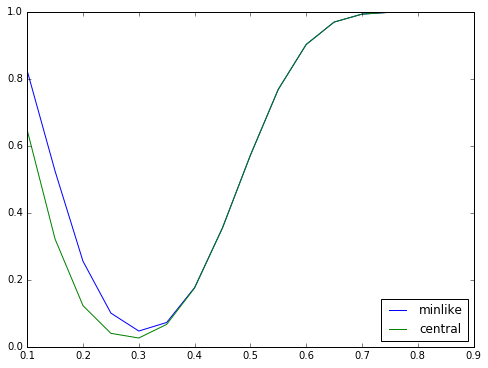

In [51]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(pow_bt[:, 0], pow_bt[:, 1], label='minlike')
plt.plot(pow_bt[:, 0], pow_bt[:, 2], label='central')
plt.legend(loc='lower right')
#plt.show()

From the plot we can see that both binomial test have the same power for large true proportions, but the standard minlike binomial test is more powerful than the central binomial test for small true proportions. For example, if the true proportion is 0.15, then the probability of rejecting the null hypothesis are 0.52 versus 0.32. We can verify that the two R packages produce the same result

In [52]:
# 0.5244758 power.binom.test(n = 30, p0 = 0.3, pa = 0.15)
# 0.321667  powerBinom(n = 30, p0 = 0.3, p1 = 0.15, strict=TRUE)
print(pow_bt[1,:])

[ 0.15        0.52447582  0.32166697]


### Power as a function of nobs

In [53]:
nobs_arr = np.arange(30, 100)
#this doesn't work vectorized in nobs
pbcentral_nobs = [power_binom_proptest(binom_test_centered, p_null, 0.5, nobs_) for nobs_ in nobs_arr]
pbcentral_nobs

[(0.57223643921315681, (3, 15)),
 (0.6399669107049708, (4, 15)),
 (0.56998461764305863, (4, 16)),
 (0.63583922386169445, (4, 16)),
 (0.56791996222455055, (4, 17)),
 (0.63206233229720976, (4, 17)),
 (0.69114679822814651, (5, 17)),
 (0.62858903440064717, (5, 18)),
 (0.68645084290255953, (5, 18)),
 (0.7388025247055342, (5, 18)),
 (0.68209018097786611, (6, 19)),
 (0.7336478091810934, (6, 19)),
 (0.67801693625369797, (6, 20)),
 (0.72880881213382032, (6, 20)),
 (0.77431005532071151, (6, 20)),
 (0.72425939575356324, (7, 21)),
 (0.76930532470325352, (7, 21)),
 (0.80915383662430451, (7, 21)),
 (0.76456080520956615, (7, 22)),
 (0.80419952705314313, (8, 22)),
 (0.76005675092873848, (8, 23)),
 (0.79946934784191803, (8, 23)),
 (0.83412532028134168, (8, 23)),
 (0.79494925223816315, (9, 24)),
 (0.82955489381149028, (9, 24)),
 (0.85969535796997965, (9, 24)),
 (0.82515915208675972, (9, 25)),
 (0.85537850209764454, (10, 25)),
 (0.88147666844959838, (10, 25)),
 (0.85120253117177069, (10, 26)),
 (0.877469

In [54]:
pbminlike_nobs = [power_binom_proptest(smprop.binom_test, p_null, 0.5, nobs_) for nobs_ in nobs_arr]
pbminlike_nobs

[(0.57226196210831415, (4, 15)),
 (0.6399669107049708, (4, 15)),
 (0.56998461764305863, (4, 16)),
 (0.63583922386169445, (4, 16)),
 (0.69620740180835128, (4, 16)),
 (0.63207178033189859, (5, 17)),
 (0.69114679822814651, (5, 17)),
 (0.74431582297256682, (5, 17)),
 (0.68645084290255953, (5, 18)),
 (0.7388025247055342, (5, 18)),
 (0.68209018097786611, (6, 19)),
 (0.7336478091810934, (6, 19)),
 (0.77960188076758619, (6, 19)),
 (0.81981199159417895, (6, 19)),
 (0.77431223359280932, (7, 20)),
 (0.81435254341931784, (7, 20)),
 (0.76930532470325352, (7, 21)),
 (0.80915383662430451, (7, 21)),
 (0.84383690828378721, (7, 21)),
 (0.80419952705314313, (8, 22)),
 (0.83888242159912874, (8, 22)),
 (0.86878157550036506, (8, 22)),
 (0.83412613720018536, (9, 23)),
 (0.86416102739275724, (9, 23)),
 (0.82955489381149028, (9, 24)),
 (0.85969535796997965, (9, 24)),
 (0.88559735796142425, (9, 24)),
 (0.85537850209764454, (10, 25)),
 (0.88147666844959838, (10, 25)),
 (0.90373690643325377, (10, 25)),
 (0.877469

In [55]:
pbcentral_nobs_arr, rej_minlike = list(zip(*pbcentral_nobs))
pbcentral_nobs_arr
pbminlike_nobs_arr, rej_minlike = list(zip(*pbminlike_nobs))
np.column_stack((nobs_arr, pbminlike_nobs_arr, pbcentral_nobs_arr))

array([[ 30.        ,   0.57226196,   0.57223644],
       [ 31.        ,   0.63996691,   0.63996691],
       [ 32.        ,   0.56998462,   0.56998462],
       [ 33.        ,   0.63583922,   0.63583922],
       [ 34.        ,   0.6962074 ,   0.56791996],
       [ 35.        ,   0.63207178,   0.63206233],
       [ 36.        ,   0.6911468 ,   0.6911468 ],
       [ 37.        ,   0.74431582,   0.62858903],
       [ 38.        ,   0.68645084,   0.68645084],
       [ 39.        ,   0.73880252,   0.73880252],
       [ 40.        ,   0.68209018,   0.68209018],
       [ 41.        ,   0.73364781,   0.73364781],
       [ 42.        ,   0.77960188,   0.67801694],
       [ 43.        ,   0.81981199,   0.72880881],
       [ 44.        ,   0.77431223,   0.77431006],
       [ 45.        ,   0.81435254,   0.7242594 ],
       [ 46.        ,   0.76930532,   0.76930532],
       [ 47.        ,   0.80915384,   0.80915384],
       [ 48.        ,   0.84383691,   0.76456081],
       [ 49.        ,   0.80419

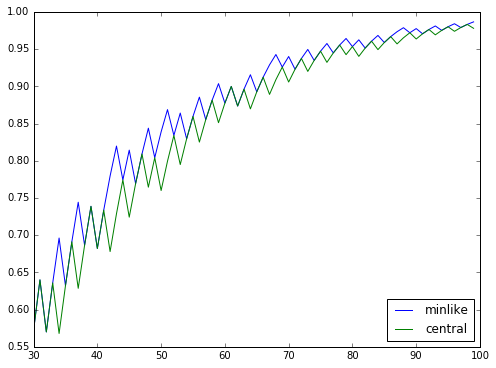

In [56]:
plt.figure(figsize=(8, 6))
plt.plot(nobs_arr, pbminlike_nobs_arr, label='minlike')
plt.plot(nobs_arr, pbcentral_nobs_arr, label='central')
plt.legend(loc='lower right')

In [57]:
xx = (np.arange(10)<4) | (np.arange(10) > 6)
print(xx)
np.nonzero(np.diff(xx))[0]

[ True  True  True  True False False False  True  True  True]


array([3, 6], dtype=int64)

In [58]:
p_null, nobs


(0.3, 30)

## Power and tests based on normal distribution


The following is still messy. The formulas look simple but are a bit confusing. There are also several different version for normal distribution based hypothesis tests and power calculations. The examples try to match up some examples from various references but that is not completely successful yet, either because of bugs in my code or because different versions are used.

Lachine summarizes sample size calculations for proportions based on the normal distribution if we only consider the power in one tail. In this case we have an explicit formula for the required sample size. This is a good approximation to two sided tests if the probability to be in the small tail is negligible and useful for quick calculations. However, solving the sample size that correctly takes both tails into account can be done numerically without much computational effort.

In [59]:
# from Lachine 1981 equ (3) and (4)

from scipy import stats
def sample_size_normal_greater(diff, std_null, std_alt, alpha=0.05, power=0.9):
    crit_alpha, crit_pow = stats.norm.isf(alpha), stats.norm.isf(1 - power)
    return ((crit_alpha * std_null + crit_pow * std_alt) / np.abs(diff))**2

def power_normal_greater(diff, std_null, std_alt, nobs, alpha=0.05):
    crit_alpha = stats.norm.isf(alpha)
    crit_pow = (np.sqrt(nobs) * np.abs(diff) - crit_alpha * std_null) / std_alt
    return stats.norm.cdf(crit_pow)

In [60]:
pa = 0.5
power_normal_greater(pa - p_null, np.sqrt(p_null * (1 - p_null)), np.sqrt(pa * (1 - pa)), 30, alpha=0.05)

0.75280935132909166

In [61]:
std_null, std_alt = np.sqrt(p_null * (1 - p_null)), np.sqrt(pa * (1 - pa))
sample_size_normal_greater(pa - p_null, std_null, std_alt, alpha=0.05, power=0.7528)

29.999189245636149

In [62]:
p0 = 0.6
pa = 0.5
power_normal_greater(pa - p0, np.sqrt(p0 * (1 - p0)), np.sqrt(pa * (1 - pa)), 25, alpha=0.05)

0.27039432496290688

In [63]:
p0 = 0.5
pa = 0.4
power_normal_greater(pa - p0, np.sqrt(p0 * (1 - p0)), np.sqrt(pa * (1 - pa)), 50, alpha=0.05)

0.40695068348471369

In [64]:
p0 = 0.3
pa = 0.5
diff = pa - p0
power_normal_greater(diff, np.sqrt(p0 * (1 - p0)), np.sqrt(pa * (1 - pa)), 50, alpha=0.05)

0.90673162370556504

In [65]:
p0 = 0.5
pa = 0.5
diff = pa - p0
diff = 0.2
power_normal_greater(diff, np.sqrt(p0 * (1 - p0)), np.sqrt(pa * (1 - pa)), 50, alpha=0.025)
# 0.80743 PASS manual example Chow, Shao, and Wang (2008)  2-sided S(Phat)

0.80742957881382105

In [66]:
p0 = 0.5
pa = 0.6
diff = pa - p0
power_normal_greater(diff, np.sqrt(p0 * (1 - p0)), np.sqrt(pa * (1 - pa)), 153, alpha=0.05)
# 0.80125 PASS doc example from Ryan (2013) for one-sided alternative

0.80125278346378259

In [67]:
# copied and adjusted from statsmodels.stats.power
def normal_power(effect_size, nobs, alpha, alternative='two-sided', std_null=1, std_alt=1):
    '''Calculate power of a normal distributed test statistic

    '''
    d = effect_size

    if alternative in ['two-sided', '2s']:
        alpha_ = alpha / 2.  #no inplace changes, doesn't work
    elif alternative in ['smaller', 'larger']:
        alpha_ = alpha
    else:
        raise ValueError("alternative has to be 'two-sided', 'larger' " +
                         "or 'smaller'")

    pow_ = 0
    if alternative in ['two-sided', '2s', 'larger']:
        crit = stats.norm.isf(alpha_)
        pow_ = stats.norm.sf((crit* std_null - d*np.sqrt(nobs))/std_alt)
        crit_pow = (np.sqrt(nobs) * np.abs(diff) - crit * std_null) / std_alt
    if alternative in ['two-sided', '2s', 'smaller']:
        crit = stats.norm.ppf(alpha_)
        pow_ += stats.norm.cdf((crit* std_null - d*np.sqrt(nobs))/std_alt)
    return pow_ #, (crit* std_null - d*np.sqrt(nobs))/std_alt, (crit* std_null - d*np.sqrt(nobs))/std_alt, crit_pow


In [68]:
p0 = 0.5
pa = 0.5
alpha = 0.05
nobs_ = 50
effect_size = diff = 0.2
std_null, std_alt = np.sqrt(p0 * (1 - p0)), np.sqrt(pa * (1 - pa))
po = normal_power(effect_size, nobs_, alpha, alternative='two-sided', std_null=std_null, std_alt=std_null)
print(po, 1-po)
# close to above 0.80742957881382105, closer to pass 0.80743

0.807430419433 0.192569580567


In [69]:
p0 = 0.5
pa = 0.6
diff = pa - p0
effect_size = diff
nobs_ = 153
alpha = 0.05
std_null, std_alt = np.sqrt(p0 * (1 - p0)), np.sqrt(pa * (1 - pa))
po = normal_power(effect_size, nobs_, alpha, alternative='larger', std_null=std_null, std_alt=std_alt)
# 0.80125 PASS doc example from Ryan (2013) for one-sided alternative
print(power_normal_greater(diff, np.sqrt(p0 * (1 - p0)), np.sqrt(pa * (1 - pa)), 153, alpha=0.05))
po

0.801252783464


0.80125278346378259

check size (power at null)

In [70]:
p0 = 0.6
pa = 0.6
diff = pa - p0
effect_size = diff
nobs_ = 153
alpha = 0.05
std_null, std_alt = np.sqrt(p0 * (1 - p0)), np.sqrt(pa * (1 - pa))
po = normal_power(effect_size, nobs_, alpha, alternative='larger', std_null=std_null, std_alt=std_alt)
po

0.049999999999999975

Next we try exact power for the already available proportion_ztest

In [71]:
p0 = 0.5
pa = 0.6
diff = pa - p0
smprop.proportions_ztest(nobs_ * (pa), nobs_, value=p0, alternative='two-sided', prop_var=p0)

(2.4738633753705956, 0.013366080075435313)

In [72]:
#power_binom_proptest(smprop.proportions_ztest, p0, pa, nobs_, use_idx=1)  #this raises exception

pzt = lambda x, nobs, p_null: smprop.proportions_ztest(x, nobs, value=p_null, prop_var=p_null)
power_binom_proptest(pzt, p0, pa, nobs_, item=1, use_idx=1)   #use_idx=False raises exception

(0.70824505759861689,
 array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
        102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
        115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
        128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
        141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153]))

In [73]:
p0, pa, nobs_

(0.5, 0.6, 153)

In [74]:
pv = [smprop.proportions_ztest(x, nobs_, value=p0, alternative='two-sided', prop_var=p0)[1] for x in np.arange(60, 99)]
pv = np.asarray(pv)
np.column_stack((np.arange(60, 99), pv, pv <=0.05))

array([[  6.00000000e+01,   7.63288179e-03,   1.00000000e+00],
       [  6.10000000e+01,   1.22036066e-02,   1.00000000e+00],
       [  6.20000000e+01,   1.90520464e-02,   1.00000000e+00],
       [  6.30000000e+01,   2.90490222e-02,   1.00000000e+00],
       [  6.40000000e+01,   4.32662880e-02,   1.00000000e+00],
       [  6.50000000e+01,   6.29648259e-02,   0.00000000e+00],
       [  6.60000000e+01,   8.95550744e-02,   0.00000000e+00],
       [  6.70000000e+01,   1.24523921e-01,   0.00000000e+00],
       [  6.80000000e+01,   1.69327297e-01,   0.00000000e+00],
       [  6.90000000e+01,   2.25252906e-01,   0.00000000e+00],
       [  7.00000000e+01,   2.93264235e-01,   0.00000000e+00],
       [  7.10000000e+01,   3.73843327e-01,   0.00000000e+00],
       [  7.20000000e+01,   4.66854271e-01,   0.00000000e+00],
       [  7.30000000e+01,   5.71450573e-01,   0.00000000e+00],
       [  7.40000000e+01,   6.86046505e-01,   0.00000000e+00],
       [  7.50000000e+01,   8.08365156e-01,   0.0000000

The power using the exact distribution is lower than using the asymptotic normal distribution.
The rejection region looks correct, so how do we verify that we calculated the power correctly?


PASS reports the following values

```
                          Exact  Z-Test  Z-Test  Z-Test  Z-Test
                  Target   Test   S(P0)  S(P0)C    S(P)   S(P)C
n    P0     P1    Alpha   Power   Power   Power   Power   Power
10 0.5000 0.6000 0.0500 0.04804 0.04804 0.04804 0.17958 0.17958
50 0.5000 0.6000 0.0500 0.23706 0.33613 0.23706 0.33613 0.23706
```

In [75]:
p0, pa, nobs_ = 0.5, 0.6, 50
power_binom_proptest(pzt, p0, pa, nobs_, item=1, use_idx=1)

(0.33613256480043147,
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
        47, 48, 49, 50]))

0.33613 is the same as reported by PASS for the exact power of the score test, `S(P0)`. Unfortunately for testing purposes, in this example Wald and score test report identical numbers for n=50.

In [76]:
pzt_wald = lambda x, nobs, p_null: smprop.proportions_ztest(x, nobs, value=p_null, prop_var=None)
power_binom_proptest(pzt_wald, p0, pa, nobs_, item=1, use_idx=1)

(0.33613256480043147,
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
        47, 48, 49, 50]))

10 0.5000 0.6000 0.0500 0.04804 0.04804 0.04804 0.17958 0.17958

In [77]:
nobs_ = 10
pzt_wald = lambda x, nobs, p_null: smprop.proportions_ztest(x, nobs, value=p_null, prop_var=None)
power_binom_proptest(pzt_wald, p0, pa, nobs_, item=1, use_idx=1)

(0.17958430719999999, array([ 0,  1,  2,  8,  9, 10]))

This is the same as the Wald test, while the score test has much lower  power in this example. It is only around 0.048 which is the same in PASS and our calculations at the provided print precision.

In [78]:
power_binom_proptest(pzt, p0, pa, nobs_, item=1, use_idx=1)

(0.048035123200000036, array([ 0,  1,  9, 10]))

Know we know how to use it, and I added keywords to the `power_binom_proptest` above, we can drop the use of lambda functions.

In [79]:
power_binom_proptest(smprop.proportions_ztest, p0, pa, nobs_, item=1, use_idx=1)

(0.17958430719999999, array([ 0,  1,  2,  8,  9, 10]))

In [80]:
power_binom_proptest(smprop.proportions_ztest, p0, pa, nobs_, kwds={'prop_var': p0}, item=1, use_idx=1)

(0.048035123200000036, array([ 0,  1,  9, 10]))

In [81]:
print(power_binom_proptest(smprop.proportions_ztest, p0, pa, nobs_, item=1, use_idx=0))
print(power_binom_proptest(smprop.proportions_ztest, p0, pa, nobs_, kwds={'prop_var': p0}, item=1, use_idx=0))

(0.17958430720000004, (2, 8))
(0.048035123199999974, (1, 9))


## Summary

Now, we have almost all the necessary pieces working and verified on a few example. The next step is to clean this up, convert it to usage friendly function or classes and convert the examples to unit tests.

We have now two exact hypothesis tests, `minlike` and `central`, two tests based on asymptotic normality, `wald` and `score`, and we have three ways of calculating the power, using the exact distribution, using the asymptotic normal distribution, and the already existing power calculation based on effect size that does not distinguish that variance is different under the null and under the alternative.

We are still missing some examples, power calculations for confidence intervals and equivalence tests, where some functions are already available in statsmodels.stats.proportions. We still need a function that finds the sample size given the functions for the power. 
Vectorization for different alternatives or number of observations depends on the implementation details and does not work across all cases. 

## trying more

The rest below is just some unsorted experiments to try a few more things.

TODO: The following is not correct because when we change the sample size, then the rejection region also changes.

In [82]:
[power_binom_reject(4, 15, p_null, nobs_) for nobs_ in range(30, 50)]

[0.047092254594638852,
 0.047775312714239675,
 0.051602724514375933,
 0.05859877650596669,
 0.068789625299809865,
 0.082186755965548378,
 0.098772671226915978,
 0.118489659792336,
 0.1412321565494524,
 0.16684288140347131,
 0.19511265080608356,
 0.22578351411938377,
 0.25855468655666075,
 0.29309063531712998,
 0.32903062340607336,
 0.36599901949754499,
 0.4036157318615764,
 0.44150620799796952,
 0.47931054705529291,
 0.51669138801043579]

We can also calculate this in vectorized form for the set of sample sizes and all three tests:

In [83]:
power_binom_reject(np.array([4, 3, 4]), np.array([15, 15, 14]), p_null, np.arange(30, 50)[:, None])

array([[ 0.04709225,  0.02625388,  0.07020749],
       [ 0.04777531,  0.03102743,  0.07728123],
       [ 0.05160272,  0.03820442,  0.0883212 ],
       [ 0.05859878,  0.04792633,  0.10324071],
       [ 0.06878963,  0.06032282,  0.12191353],
       [ 0.08218676,  0.07549525,  0.14416465],
       [ 0.09877267,  0.09350311,  0.16976553],
       [ 0.11848966,  0.11435385,  0.19843379],
       [ 0.14123216,  0.1379965 ,  0.2298369 ],
       [ 0.16684288,  0.16431907,  0.26359926],
       [ 0.19511265,  0.19314968,  0.29931183],
       [ 0.22578351,  0.22426089,  0.33654338],
       [ 0.25855469,  0.25737665,  0.37485255],
       [ 0.29309064,  0.29218144,  0.41379979],
       [ 0.32903062,  0.32833054,  0.45295869],
       [ 0.36599902,  0.36546115,  0.49192593],
       [ 0.40361573,  0.40320337,  0.53032969],
       [ 0.44150621,  0.4411907 ,  0.56783618],
       [ 0.47931055,  0.47906961,  0.60415428],
       [ 0.51669139,  0.51650774,  0.63903825]])

## Trying out two sample proportion, incorrect if nobs is scalar instead of same length as count.

In [84]:
smprop.proportions_ztest(np.array([6,7]), nobs, value=0, alternative='two-sided', prop_var=p_null)

(-0.39840953644479782, 0.69032832946419354)

In [85]:
smprop.proportions_ztest(np.array([6,7]), nobs*np.ones(2), value=1/30, alternative='two-sided', prop_var=p_null)

(-0.56343616981901101, 0.57313791338407638)

In [86]:
smprop.proportions_ztest(np.array([6,7]), nobs, value=1/30, alternative='two-sided', prop_var=p_null)

(-0.79681907288959564, 0.42555611641912894)

In [87]:
smprop.proportions_ztest(np.array([6,7]), nobs, value=-1/30, alternative='two-sided', prop_var=p_null)

(8.293564511085938e-17, 0.99999999999999989)

In [88]:
smprop.proportions_ztest(np.array([6,7]), nobs*np.ones(2), value=-1/30, alternative='two-sided', prop_var=p_null)

(5.864435705996961e-17, 1.0)

In [89]:
#?smprop.proportion_confint()

In [90]:
smprop.proportion_confint(count, nobs)

(0.081984475816844427, 0.38468219084982225)

In [91]:
from statsmodels.stats.proportion import proportion_effectsize
es = proportion_effectsize(0.4, 0.5)
smpow.NormalIndPower().solve_power(es, nobs1=60, alpha=0.05, ratio=0)
# R pwr 0.3447014091272153

0.34470140912721514

In [92]:
smpow.NormalIndPower().solve_power(proportion_effectsize(0.4, 0.5), nobs1=None, alpha=0.05, ratio=0, power=0.9)

259.154426739506

In [93]:
low, upp, nobs, p_alt = 0.7, 0.9, 509/2, 0.82
smprop.power_ztost_prop(low, upp, nobs, p_alt, alpha=0.025, dist='norm',
                     variance_prop=None, discrete=True, continuity=0,
                     critval_continuity=0)
    

(0.94849873047984967,
 ((0.75834970530451862,
   0.86051080550098236,
   -2.5599758686988578,
   1.6821766224528543),))

In [94]:
low, upp, nobs, p_alt = 0.7, 0.9, 419/2, 0.8
smprop.power_ztost_prop(low, upp, nobs, p_alt, alpha=0.05, dist='norm',
                     variance_prop=None, discrete=False, continuity=0,
                     critval_continuity=0)

(0.95000875677852759,
 ((0.75207687201030093,
   0.86590768457946699,
   -1.7341121433755891,
   2.3848884863189261),))

In [95]:
low, upp, nobs, p_alt = 0.7, 0.9, 417/2, 0.8
smprop.power_ztost_prop(low, upp, nobs, p_alt, alpha=0.05, dist='norm',
                     variance_prop=None, discrete=False, continuity=1,
                     critval_continuity=0)

(0.95811685170327532,
 ((0.75220160721176865,
   0.86582602622195959,
   -1.812033626524528,
   2.4628099694678625),))

In [96]:
low, upp, nobs, p_alt = 0.7, 0.9, 420/2, 0.8
smprop.power_ztost_prop(low, upp, nobs, p_alt, alpha=0.05, dist='binom',
                     variance_prop=None, discrete=False, continuity=0,
                     critval_continuity=0)

(0.95447058338704227,
 ((158.0, 181.0, 5695.1110612524499, 6528.3652241583422),))

In [97]:
low, upp, nobs, p_alt = 0.7, 0.9, 414/2, 0.8
smprop.power_ztost_prop(low, upp, nobs, p_alt, alpha=0.025, dist='norm',
                     variance_prop=None, discrete=False, continuity=1,
                     critval_continuity=0)

(0.91140841850002685,
 ((0.76242701448039996,
   0.85913192581906617,
   -1.4383338187061427,
   2.2137816599366142),))

In [98]:
low, upp, nobs = 0.4, 0.6, 100
smprop.binom_tost_reject_interval(low, upp, nobs, alpha=0.05)

(49.0, 51.0)

In [99]:
value, nobs = 0.4, 50
smprop.binom_test_reject_interval(value, nobs, alpha=0.05)

(12.0, 28.0)

In [100]:
smprop.proportion_confint(50, 100, method='beta')

(0.39832112950330101, 0.6016788704966991)

In [101]:
low, upp, nobs = 0.7, 0.9, 100
smprop.binom_tost_reject_interval(low, upp, nobs, alpha=0.05)

(78.0, 84.0)

In [102]:
low, upp, nobs, p_alt = 0.7, 0.9, 100, 0.8
smprop.power_ztost_prop(low, upp, nobs, p_alt, alpha=0.05, dist='binom',
                     variance_prop=None, discrete=False, continuity=0,
                     critval_continuity=0)

(0.65848903119285485, ((78.0, 85.0, 1930.0, 2105.0),))

In [103]:
low, upp, nobs, p_alt = 0.7, 0.9, 100, 0.8
smprop.power_binom_tost(low, upp, nobs, p_alt, alpha=0.05)

0.61042723749210825

In [104]:
low, upp, nobs, p_alt = 0.7, 0.9, 125, 0.8
smprop.power_binom_tost(low, upp, nobs, p_alt, alpha=0.05)

0.71661671146632

In [105]:
# from Lachine 1981 equ (3) and (4)

from scipy import stats
def sample_size_normal_greater(diff, std_null, std_alt, alpha=0.05, power=0.9):
    crit_alpha, crit_pow = stats.norm.isf(alpha), stats.norm.isf(1 - power)
    return ((crit_alpha * std_null + crit_pow * std_alt) / np.abs(diff))**2

def power_normal_greater(diff, std_null, std_alt, nobs, alpha=0.05):
    crit_alpha = stats.norm.isf(alpha)
    crit_pow = (np.sqrt(nobs) * np.abs(diff) - crit_alpha * std_null) / std_alt
    return stats.norm.cdf(crit_pow)

In [106]:
# Note for two sample comparison we have to adjust the standard deviation for unequal sample sizes
n_frac1 = 0.5
n_frac2 = 1 - n_frac1

# if defined by ratio: n2 = ratio * n1
ratio = 1
n_frac1 = 1 / ( 1. + ratio)
n_frac2 = 1 - n_frac1


# If we use fraction of nobs, then sample_size return nobs is total number of observations
diff = 0.2
std_null = std_alt = 1 * np.sqrt(1 / 0.5 + 1 / 0.5)
nobs = sample_size_normal_greater(diff, std_null, std_alt, alpha=0.05, power=0.9)
nobs

856.38473506679793

In [107]:
#nobs = 858
power_normal_greater(diff, std_null, std_alt, nobs, alpha=0.05)

0.89999999999999991

In [108]:
alpha=0.05; power=0.9
stats.norm.isf(alpha), stats.norm.isf(1 - power)


(1.6448536269514729, 1.2815515655446004)

In [109]:
crit_alpha = stats.norm.isf(alpha)
(np.sqrt(nobs) * np.abs(diff) - crit_alpha * std_null) / std_alt

1.2815515655446004

In [110]:
stats.norm.cdf(_)

0.89999999999999991

In [111]:
smprop.binom_test_reject_interval([0.4, 0.6], [100], alpha=0.05)

(array([ 30.,  49.]), array([ 51.,  70.]))